<a href="https://colab.research.google.com/github/ShoaibFarooqui/Emotion-Classification/blob/drainlm/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content/Faces')

In [50]:
# Set Directory to access 40 sets of pictures
face_data = '/content/Faces' 

In [53]:
# Initialize a dictionary to hold the data for each set of pictures
face_data_dict = {}

In [55]:
# Iterate over each directory (person)
for dir_name in os.listdir(face_data):
    # Get the label for this person (directory name)
    label = dir_name
    
    # Initialize a list to hold the images for this person
    images = []
    
    # Iterate over each image in the directory
    for img_name in os.listdir(os.path.join(face_data, dir_name)):
        # Load the image
        img = cv2.imread(os.path.join(face_data, dir_name, img_name), cv2.IMREAD_GRAYSCALE)

        # Normalize the pixel values (scale them between 0 and 1)
        img = img / 255.0

        # Append the preprocessed image to the list
        images.append(img)
    
    # Add the list of images to the data dictionary with the label as the key
    face_data_dict[label] = images

In [58]:
# Accessing the data for a specific set
set_number = 's32' 
set_images = face_data_dict[set_number]

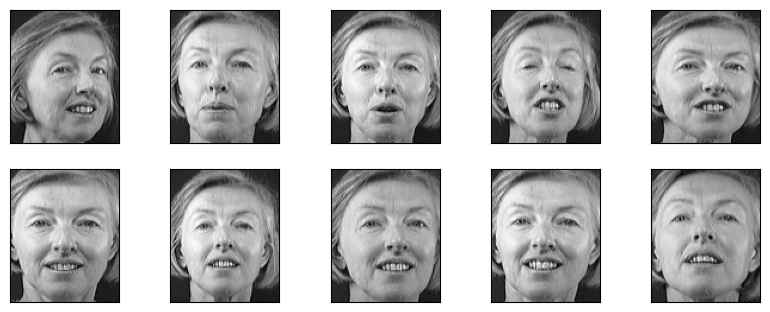

In [61]:
# Print the images from the set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.gray)
plt.show()

ValueError: ignored

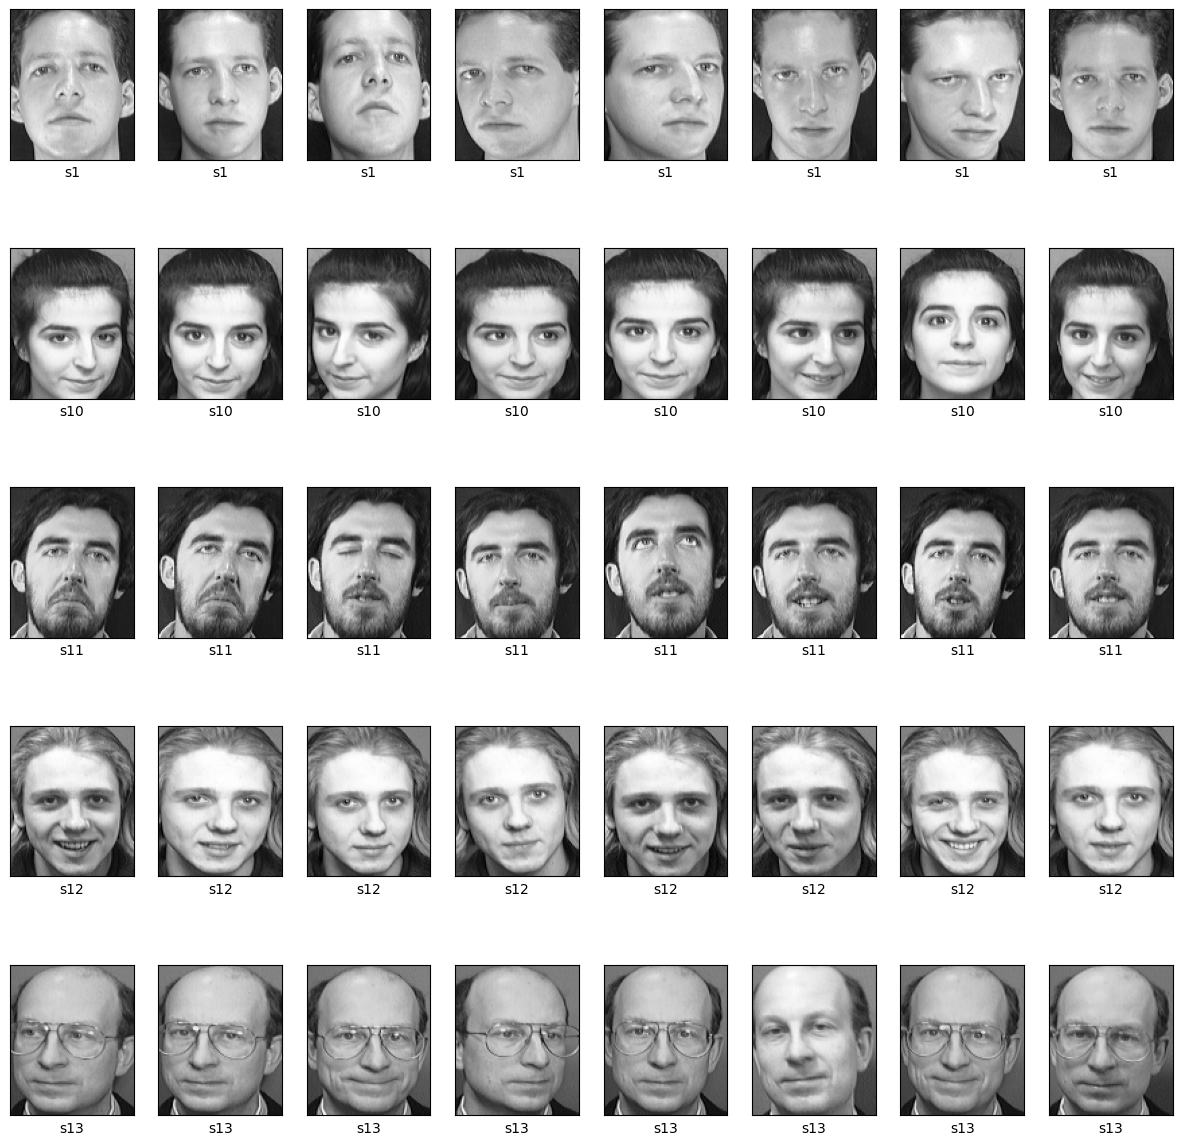

In [69]:
# Get all the unique set numbers from the data_dict keys
set_numbers = sorted(set(label[1:] for label in face_data_dict.keys()))

# Print all the images from the 'Faces' folder
plt.figure(figsize=(15, 15))
num_rows = 5  # Number of rows in the grid
num_cols = 8  # Number of columns in the grid

for i, set_number in enumerate(set_numbers):
    set_images = face_data_dict[f's{set_number}']
    
    for j, img in enumerate(set_images):
        plt.subplot(num_rows, num_cols, i*num_cols + j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.xlabel(f's{set_number}')


plt.tight_layout()
plt.show()